In [61]:
#!/usr/bin/python
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
from helper import get_features, predict_from_score, correlate, crt_plot, plt_precision_recall_vs_threshold, plt_precision_vs_recall, plot_roc_curve, flex_classifier 
import sys
import pickle
sys.path.append("../tools/")

from sklearn.metrics import confusion_matrix, precision_recall_curve, recall_score, precision_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, load_classifier_and_data, test_classifier

MODELS = '../classifiers/'
IMAGES = '../images/'
DATA   = '../data/'

----

In [2]:
#############################
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
# features_list = ['poi','salary'] # You will need to use more features
payment_features = ['salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments', 'other', 'expenses', 'director_fees', 'total_payments']
stock_features   = ['exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value']
mail_features    = ['from_this_person_to_poi', 'from_poi_to_this_person', 'shared_receipt_with_poi']
extra_features   = ['bonus_deferral_payments_rate', 'rest_stock_deferral_payments_rate', 'exer_stock_options_deferral_payments_rate',
                    'long_term_incentive_total_payments_rate', 'bonus_total_payments_rate', 'exer_stock_options_total_payments_rate',
                    'toPOI_rate', 'fromPOI_rate']
extra_finance    = ['bonus_deferral_payments_rate', 'rest_stock_deferral_payments_rate', 'exer_stock_options_deferral_payments_rate',
                    'long_term_incentive_total_payments_rate', 'bonus_total_payments_rate', 'exer_stock_options_total_payments_rate']
extra_mail       = ['toPOI_rate', 'fromPOI_rate']
feature_list = payment_features + stock_features + mail_features + extra_features

In [3]:
### Load the dictionary containing the dataset
my_data = pd.read_pickle(DATA+"my_dataFrame.pkl")
# Divide data into features and labels 
y = my_data['poi'].copy().astype(np.uint8)
X = my_data[feature_list].copy()
# Split data into training and test set using stratified splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=77, stratify=y) 

----

In [4]:
# I spare 30% of the data as test set to have at least 5 'poi's in the test set. It's important to me to realize a high recall value, identifying as many 'poi's as possible.  
print "Number of POIs in the test set:" , y_test.sum()

Number of POIs in the test set: 6


In [5]:
# Save the order of insiders
insiders_train = y_train.index
insiders_test  = y_test.index

In [6]:
# Dealing with missing values
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### Imputation Stategies

In [7]:
# I'd like to explore different strategies filling NAN values
# Imputer_01:
# Applies median to mail and extra NAN features and 0 to financial NAN features
impute_01 = ColumnTransformer(
     [('finance_data',  SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0), payment_features+stock_features),
      ('mail_data',     SimpleImputer(missing_values=np.nan, strategy='median'), mail_features),
      ('extra_finance', SimpleImputer(missing_values=np.nan, strategy='median'), extra_finance),
      ('extra_mail',    SimpleImputer(missing_values=np.nan, strategy='median'), extra_mail)],
     remainder='passthrough')
# Imputer_02:
# Applies median to all NAN features 
impute_02 = SimpleImputer(strategy='median')
# Imputer_03:
# Applies 0.0 to all NAN features
impute_03 = SimpleImputer(strategy='constant', fill_value=0.0)
# Imputer 04
# Applies 0.0 to financial and extra_finance featurtes and median to 'mail_features' and 'extra_mail'
impute_04 = ColumnTransformer(
     [('finance_data',  SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0), payment_features+stock_features),
      ('mail_data',     SimpleImputer(missing_values=np.nan, strategy='median'), mail_features),
      ('extra_finance', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0), extra_finance),
      ('extra_mail',    SimpleImputer(missing_values=np.nan, strategy='median'), extra_mail)],
     remainder='passthrough')
# Imputer 05
# Applies mean values to all NAN
impute_05 = SimpleImputer(strategy='mean')
imputers = [impute_01, impute_02, impute_03, impute_04, impute_05]

### Scaling strategies

In [8]:
def no_scaling(X):
    return np.array(X)

In [9]:
# Define different scaling strategies
#no_scl     = FunctionTransformer(func=lambda x: np.array(x))
no_scl     = FunctionTransformer(func=no_scaling)
robust_scl = RobustScaler()
std_scl    = StandardScaler()
power_scl  = PowerTransformer(method='yeo-johnson')
scalers = [no_scl, robust_scl, std_scl, power_scl]
scaler_names = ['NO SCALING', 'ROBUST SCALER', 'STANDARD SCALER', 'POWER SCALER']

----

### Stochastic gradient decent

In [10]:
from sklearn.linear_model import SGDClassifier  

In [11]:
SGD_clf = SGDClassifier(random_state=77, loss='hinge')

In [12]:
# Build pipelines for imputation and scaling
pipe_41 = Pipeline([ ('impute_04', impute_04), ('scale', no_scl) ])
pipe_44 = Pipeline([ ('impute_04', impute_04), ('scale', power_scl) ])

X_train_41 = pipe_41.fit_transform(X_train);
X_train_44 = pipe_44.fit_transform(X_train);

C:\Users\micha\Programs\anaconda3\envs\py27\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


----

## Feature selection

### Try different sets of features and check the impact on the results (ROC AUC)

In [13]:
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

### Initial run of SGD 

In [14]:
scores = cross_val_score(SGD_clf, X_train_44, y_train, cv=6, scoring='roc_auc')
scores.mean()

C:\Users\micha\Programs\anaconda3\envs\py27\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.9182539682539682

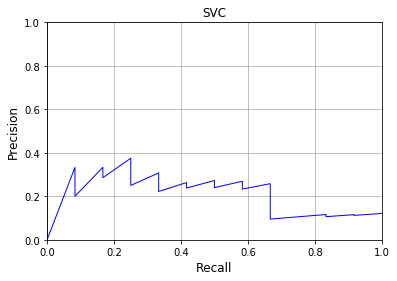

In [15]:
y_scores = cross_val_predict(SGD_clf, X_train_41, y_train, cv=6, method='decision_function' )
roc_auc_score(y_train, y_scores)
precision, recall, proba = precision_recall_curve(y_train, y_scores)
plt_precision_vs_recall(precision, recall, title='SVC')

#### Feature reduction

In [16]:
from sklearn.feature_selection import RFE, RFECV

In [17]:
RFE_ = RFE(SGD_clf).fit(X_train_44, y_train)

In [18]:
RFE_.ranking_

array([ 1,  7,  1,  1, 10,  1,  1,  4, 13,  1,  6,  9,  1,  5, 12,  1,  1,
        3,  1, 11,  1,  8,  1,  2])

In [19]:
X_train_44_red = pipe_44.transform(X_train)[:, RFE_.ranking_ <= 1]
X_test_44_red = pipe_44.transform(X_test)[:, RFE_.ranking_ <= 1]

0.9090909090909091 ROC AUC for


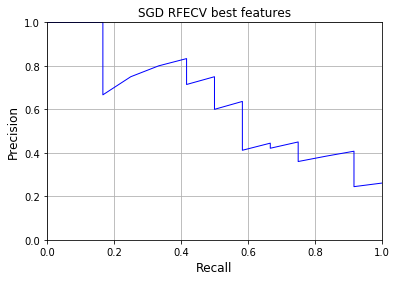

In [20]:
# RFECV features reduction. RFB Kernel results.
y_scores = cross_val_predict(SGD_clf, X_train_44_red, y_train, cv=6, method='decision_function')
print roc_auc_score(y_train, y_scores), "ROC AUC for"
precision, recall, proba = precision_recall_curve(y_train, y_scores)
plt_precision_vs_recall(precision, recall, title='SGD RFECV best features')

In [21]:
score_table = pd.DataFrame(zip(feature_list, RFE_.ranking_))
score_table.sort_values(1, axis='index')

,0,1
0,salary,1
20,bonus_total_payments_rate,1
2,long_term_incentive,1
3,deferred_income,1
18,exer_stock_options_deferral_payments_rate,1
5,other,1
6,expenses,1
16,bonus_deferral_payments_rate,1
15,shared_receipt_with_poi,1
9,exercised_stock_options,1


### Random search to find best set of features

Find best parameters for SGD model using Randomized Search algorithm

In [22]:
from sklearn.model_selection import RandomizedSearchCV 

In [23]:
param_distributions = {
            'penalty': ['l2', 'l1'],
            'alpha': stats.reciprocal(10**(-6), 100),
            'learning_rate': ['constant', 'invscaling', 'adaptive'],
            'eta0': stats.uniform(10**-12,100)
        }
#stats.expon(scale=1.0),

In [24]:
RandSearch = RandomizedSearchCV(SGD_clf, param_distributions, cv=6, n_iter=5000, scoring='roc_auc', iid=False, verbose=1, n_jobs=8, random_state=77)

In [25]:
RandSearch.fit(X_train_44_red, y_train)

Fitting 6 folds for each of 5000 candidates, totalling 30000 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done 1734 tasks      | elapsed:    6.8s
[Parallel(n_jobs=8)]: Done 5234 tasks      | elapsed:   11.5s
[Parallel(n_jobs=8)]: Done 10134 tasks      | elapsed:   17.9s
[Parallel(n_jobs=8)]: Done 16434 tasks      | elapsed:   27.0s
[Parallel(n_jobs=8)]: Done 24134 tasks      | elapsed:   36.7s
[Parallel(n_jobs=8)]: Done 30000 out of 30000 | elapsed:   44.1s finished


RandomizedSearchCV(cv=6, error_score='raise-deprecating',
          estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=77, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid=False, n_iter=5000, n_jobs=8,
          param_distributions={'penalty': ['l2', 'l1'], 'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000D4B4DC8>, 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000C9974C8>},
          pre_dispatch='2*n_jobs', random_state=77, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=1)

In [26]:
RandSearch.best_score_

0.9765873015873017

In [27]:
RandSearch.best_params_

{'alpha': 0.0005892203698233472,
 'eta0': 26.256751654630218,
 'learning_rate': 'adaptive',
 'penalty': 'l1'}

0.9507575757575757 ROC AUC for


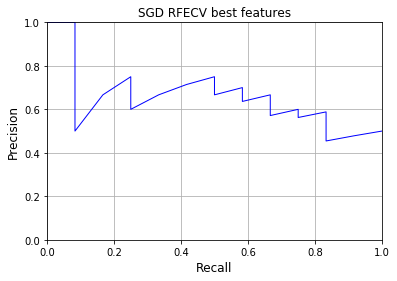

In [28]:
y_scores = cross_val_predict(RandSearch.best_estimator_, X_train_44_red, y_train, cv=6, method='decision_function')
print roc_auc_score(y_train, y_scores), "ROC AUC for"
precision, recall, proba = precision_recall_curve(y_train, y_scores)
plt_precision_vs_recall(precision, recall, title='SGD RFECV best features')

In [29]:
SGD_adapt = RandSearch.best_estimator_

In [30]:
param_distributions = {
            'penalty': ['l2', 'l1'],
            'alpha': stats.reciprocal(10**(-6), 100),
            #'learning_rate': ['constant', 'invscaling', 'adaptive'],
            #'eta0': stats.uniform(10**-12,100)
        }
#stats.expon(scale=1.0),

In [31]:
RandSearch = RandomizedSearchCV(SGD_clf, param_distributions, cv=6, n_iter=5000, scoring='roc_auc', iid=False, verbose=1, n_jobs=8, random_state=77)

In [32]:
RandSearch.fit(X_train_44_red, y_train)

Fitting 6 folds for each of 5000 candidates, totalling 30000 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 456 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 3756 tasks      | elapsed:    5.5s
[Parallel(n_jobs=8)]: Done 9256 tasks      | elapsed:   12.5s
[Parallel(n_jobs=8)]: Done 16956 tasks      | elapsed:   21.6s
[Parallel(n_jobs=8)]: Done 26856 tasks      | elapsed:   34.9s
[Parallel(n_jobs=8)]: Done 30000 out of 30000 | elapsed:   38.7s finished


RandomizedSearchCV(cv=6, error_score='raise-deprecating',
          estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=77, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid=False, n_iter=5000, n_jobs=8,
          param_distributions={'penalty': ['l2', 'l1'], 'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000CB0BB88>},
          pre_dispatch='2*n_jobs', random_state=77, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=1)

In [33]:
RandSearch.best_score_

0.9714285714285714

In [34]:
RandSearch.best_params_

{'alpha': 0.00012100737190714552, 'penalty': 'l1'}

0.9308712121212122 ROC AUC for


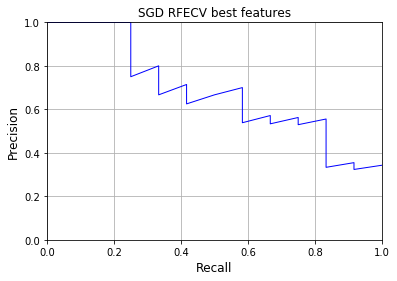

In [35]:
y_scores = cross_val_predict(RandSearch.best_estimator_, X_train_44_red, y_train, cv=6, method='decision_function')
print roc_auc_score(y_train, y_scores), "ROC AUC for"
precision, recall, proba = precision_recall_curve(y_train, y_scores)
plt_precision_vs_recall(precision, recall, title='SGD RFECV best features')

In [36]:
SGD_opt = RandSearch.best_estimator_

In [37]:
param_distributions = {
            'penalty': ['l2', 'l1'],
            'alpha': stats.reciprocal(10**(-6), 20),
            'learning_rate': ['invscaling'],
            'eta0': stats.uniform(10**-12,20),
            'power_t': stats.uniform(10**-12,5)
        }
#stats.expon(scale=1.0),

In [38]:
RandSearch = RandomizedSearchCV(SGD_clf, param_distributions, cv=6, n_iter=5000, scoring='roc_auc', iid=False, verbose=1, n_jobs=8, random_state=77)

In [39]:
RandSearch.fit(X_train_44_red, y_train)

Fitting 6 folds for each of 5000 candidates, totalling 30000 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 268 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 2368 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done 5868 tasks      | elapsed:    8.0s
[Parallel(n_jobs=8)]: Done 10768 tasks      | elapsed:   14.3s
[Parallel(n_jobs=8)]: Done 17068 tasks      | elapsed:   23.1s
[Parallel(n_jobs=8)]: Done 24768 tasks      | elapsed:   34.1s
[Parallel(n_jobs=8)]: Done 30000 out of 30000 | elapsed:   40.9s finished


RandomizedSearchCV(cv=6, error_score='raise-deprecating',
          estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=77, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid=False, n_iter=5000, n_jobs=8,
          param_distributions={'penalty': ['l2', 'l1'], 'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000D8E3648>, 'learning_rate': ['invscaling'], 'eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000322F6C8>, 'power_t': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000D8E3E88>},
          pre_dispatch='2*n_jobs', random_state=77, refit=True,
          return_train_score='warn', scoring='roc_a

In [40]:
RandSearch.best_score_

0.9769841269841271

In [41]:
RandSearch.best_params_

{'alpha': 1.5781162887866865e-06,
 'eta0': 6.999733775493985,
 'learning_rate': 'invscaling',
 'penalty': 'l1',
 'power_t': 0.02425337308074562}

0.9545454545454546 ROC AUC for


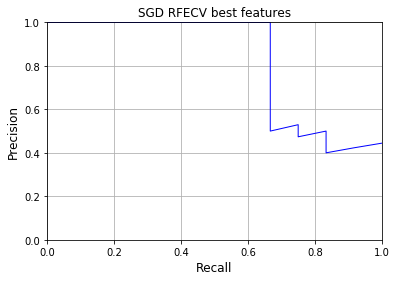

In [42]:
y_scores = cross_val_predict(RandSearch.best_estimator_, X_train_44_red, y_train, cv=6, method='decision_function')
print roc_auc_score(y_train, y_scores), "ROC AUC for"
precision, recall, proba = precision_recall_curve(y_train, y_scores)
plt_precision_vs_recall(precision, recall, title='SGD RFECV best features')

In [43]:
SGD_inv = RandSearch.best_estimator_

## Make predictions on test set

### Train the models

In [44]:
SGD_opt.fit(X_train_44_red, y_train)

SGDClassifier(alpha=0.00012100737190714552, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=77, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [45]:
SGD_adapt.fit(X_train_44_red, y_train)

SGDClassifier(alpha=0.0005892203698233472, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=26.256751654630218,
       fit_intercept=True, l1_ratio=0.15, learning_rate='adaptive',
       loss='hinge', max_iter=None, n_iter=None, n_iter_no_change=5,
       n_jobs=None, penalty='l1', power_t=0.5, random_state=77,
       shuffle=True, tol=None, validation_fraction=0.1, verbose=0,
       warm_start=False)

In [46]:
SGD_inv.fit(X_train_44_red,y_train)

SGDClassifier(alpha=1.5781162887866865e-06, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=6.999733775493985,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='hinge', max_iter=None, n_iter=None, n_iter_no_change=5,
       n_jobs=None, penalty='l1', power_t=0.02425337308074562,
       random_state=77, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

ROC AUC for SGD learning rate "optimal" : 0.75
ROC AUC for SGD,learning rate "adopted" : 0.8114035087719299
ROC AUC for SGD,learning rate "invscaling" : 0.8114035087719298


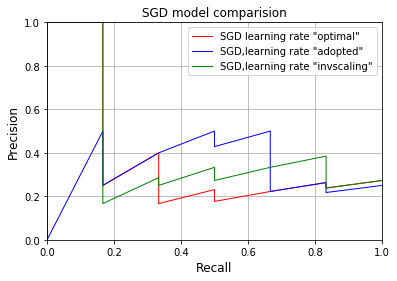

In [47]:
classifiers = [SGD_opt, SGD_adapt, SGD_inv]
clf_names = ['SGD learning rate "optimal"', 'SGD,learning rate "adopted"', 'SGD,learning rate "invscaling"']
colors = ['red', 'blue', 'green']
for clf, label, color in zip(classifiers, clf_names, colors):
    y_scores = clf.decision_function(X_test_44_red)
    print "ROC AUC for", label, ":", roc_auc_score(y_test, y_scores)
    precision, recall, proba = precision_recall_curve(y_test, y_scores)
    plt_precision_vs_recall(precision, recall, title='SGD model comparision', color=color, label=label)

----

### Address precision/ recall trade-off

In [48]:
my_SGD_opt   = flex_classifier(SGD_opt, min_precision=0.35, min_recall=0.4, maximize='recall')
my_SGD_adapt = flex_classifier(SGD_adapt, min_precision=0.35, min_recall=0.4, maximize='recall')
my_SGD_inv   = flex_classifier(SGD_inv, min_precision=0.35, min_recall=0.4, maximize='recall')

In [49]:
my_SGD_opt.fit(X_train_44_red, y_train)
my_SGD_adapt.fit(X_train_44_red, y_train) 
my_SGD_inv.fit(X_train_44_red, y_train);

#### Determine best threshold

In [50]:
from sklearn.model_selection import StratifiedShuffleSplit

In [51]:
cv = StratifiedShuffleSplit(n_splits=14, random_state=77, test_size=0.35)

In [52]:
my_SGD_opt.det_threshold(X_train_44_red, y_train, replace=False)

(-22.28096379376656, 0.8333333333333334, 0.5555555555555556)

In [53]:
my_classifiers = [my_SGD_opt, my_SGD_adapt, my_SGD_inv]
for classifier, name in zip(my_classifiers, clf_names):
    thresholds = []
    for train_idx, test_idx in cv.split(X_train_44_red, y_train):
        X_train_ = X_train_44_red[train_idx]
        X_test_  = X_train_44_red[test_idx]
        y_train_ = y_train[train_idx]
        y_test_  = y_train[test_idx]
        #print my_SGD_opt.det_threshold(X_train_, y_train_, replace=False)
        #print my_SGD_opt.feasibiliy
        thresholds.append( list(classifier.det_threshold(X_train_, y_train_, replace=False)))
    thresholds = np.array(thresholds)
    best_threshold = thresholds[:,0].mean(axis=0)
    classifier.threshold = best_threshold
    print name, ":", best_threshold

SGD learning rate "optimal" : -19.839056331311337
SGD,learning rate "adopted" : -59.863913137773686
SGD,learning rate "invscaling" : -13.127204655755417


#### Check model on test data

In [56]:
for classifier, name in zip(my_classifiers, clf_names):
    y_predict = classifier.predict(X_test_44_red)
    print name
    print confusion_matrix(y_test, y_predict)
    print "Recall:", recall_score(y_test, y_predict)
    print "Precision", precision_score(y_test, y_predict)

SGD learning rate "optimal"
[[26 12]
 [ 3  3]]
Recall: 0.5
Precision 0.2
SGD,learning rate "adopted"
[[28 10]
 [ 2  4]]
Recall: 0.6666666666666666
Precision 0.2857142857142857
SGD,learning rate "invscaling"
[[30  8]
 [ 2  4]]
Recall: 0.6666666666666666
Precision 0.3333333333333333


----

### Validate model

In [57]:
selected_features = get_features(feature_list,  RFE_.ranking_ <= 1)
selected_features

['salary',
 'long_term_incentive',
 'deferred_income',
 'other',
 'expenses',
 'exercised_stock_options',
 'total_stock_value',
 'shared_receipt_with_poi',
 'bonus_deferral_payments_rate',
 'exer_stock_options_deferral_payments_rate',
 'bonus_total_payments_rate',
 'toPOI_rate']

In [58]:
# Features
X_train_44_red_df = pd.DataFrame(X_train_44_red, columns=selected_features, index=insiders_train)
X_test_44_red_df = pd.DataFrame(X_test_44_red, columns=selected_features, index=insiders_test)
X_44_df = X_train_44_red_df.append(X_test_44_red_df, sort=False)

# Labels
y_df = y_train.append(y_test)

# Combine features and labels 
my_dataset = X_44_df.copy()
my_dataset.insert(0, column='poi', value=y_df)

# Create dataset dict for validation
my_dataset_dict = my_dataset.transpose().to_dict() 

In [59]:
# Dump data           
for classifier, name in zip(my_classifiers, clf_names):
    dump_classifier_and_data(classifier, my_dataset_dict, ['poi'] + selected_features)
    clf, dataset, feature_list = load_classifier_and_data()
    print name
    test_classifier(clf, dataset, feature_list)

SGD learning rate "optimal"
flex_classifier(classifier=SGDClassifier(alpha=0.00012100737190714552, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=77, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
        maximize='recall', min_precision=0.35, min_recall=0.4,
        threshold=-19.839056331311337)
	Accuracy: 0.79293	Precision: 0.35871	Recall: 0.70200	F1: 0.47481	F2: 0.58922
	Total predictions: 15000	True positives: 1404	False positives: 2510	False negatives:  596	True negatives: 10490

SGD,learning rate "adopted"
flex_classifier(classifier=SGDClassifier(alpha=0.0005892203698233472, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=26.256751654630218,
       fit_intercept=True, l1_ratio=

---

### Save best model

In [63]:
with open(MODELS + "SGD_model.pkl", "w") as out:
    pickle.dump(my_SGD_opt, out)

In [64]:
with open(MODELS + "SGD_features.pkl", "w") as out:
    pickle.dump(my_dataset_dict, out)

In [65]:
with open(MODELS + "SGD_feature_list.pkl", "w") as out:
    pickle.dump(['poi'] + selected_features, out)